In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import os
import re
import torch
import random
from dash import Dash, dcc, html, Input, Output, State
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from geopy.geocoders import Nominatim
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
### WARNING : in env\Lib\site-packages\torch_geometric_temporal\nn\attention\tsagcn.py :
### change 'from torch_geometric.utils.to_dense_adj' by 'from torch_geometric.utils'
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import DCRNN, GConvGRU
from sklearn.model_selection import TimeSeriesSplit

from gnn_model import StationFlowGCN
from train_gnn import(
    train_gnn_model,
    eval_gnn_model,
)
from utils.station_network import StationNetworkSimul
from utils.data import get_degraded_network_loader, create_degraded_networks
from utils.metrics import MAPE_loss


In [3]:
def create_numbat_dataframe(data_dir, year, weekdays, sheet_name):
    df_numbat = pd.DataFrame()
    for weekday in weekdays.keys():
        df_day = pd.read_excel(os.path.join(data_dir, f'NUMBAT {year}', f'NBT{str(year)[-2:]}{weekday}_outputs.xlsx'), sheet_name=sheet_name,skiprows=2, header=0)
        df_day['weekday'] = weekday
        df_day['weekday_idx'] = df_day['weekday'].apply(lambda x : weekdays[x])
        df_day = df_day.sort_values(by='weekday_idx')
        df_day = df_day.reset_index(drop=True)
        df_day = df_day.reset_index()
        df_numbat = pd.concat((df_numbat, df_day))
    
    rename_dict = {
        'Early     ' : 'Early',
        'AM Peak   ' : 'AM Peak',
        'Midday    ' : 'Midday',
        'PM Peak   ' : 'PM Peak',
        'Evening   ' : 'Evening',
        'Late      ' : 'Late'
    }
    df_numbat = df_numbat.rename(columns=rename_dict)
    return df_numbat

In [4]:
weekdays = {'MON':0,
 'TWT':1,
 'FRI':2,
 'SAT':3,
 'SUN':4}

data_dir = 'data/london/'

In [5]:
df_numbat_station_entries = create_numbat_dataframe(data_dir, 2023, weekdays,'Station_Entries')
df_numbat_station_exits = create_numbat_dataframe(data_dir, 2023, weekdays, 'Station_Exits')
df_numbat_link_loads = create_numbat_dataframe(data_dir, 2023, weekdays, 'Link_Loads')

In [65]:
lines_directions = {
    line : sorted(list(df_numbat_link_loads[df_numbat_link_loads['Line'] == line ]['Dir'].unique()))
    for line in df_numbat_link_loads['Line'].unique()
}
lines_directions

{'Bakerloo': ['NB', 'SB'],
 'LO West Anglia': ['NB', 'SB'],
 'London Trams': ['EB', 'WB'],
 'LO Watford-Euston': ['NB', 'SB'],
 'Metropolitan': ['NB', 'SB'],
 'LO Gospel Oak-Barking': ['EB', 'WB'],
 'LO East London': ['NB', 'SB'],
 'LO North London': ['EB', 'WB'],
 'LO Romford–Upminster': ['EB', 'WB'],
 'Piccadilly': ['EB', 'WB'],
 'Northern': ['NB', 'SB'],
 'Victoria': ['NB', 'SB'],
 'District': ['EB', 'WB'],
 'DLR': ['IB', 'OB'],
 'Central': ['EB', 'WB'],
 'Waterloo & City': ['EB', 'WB'],
 'H&C and Circle': ['IR', 'OR'],
 'Jubilee': ['NB', 'SB'],
 'Elizabeth Line': ['EB', 'WB']}

In [12]:
nlc_idx = {
    nlc : i for i, nlc in df_numbat_station_entries[df_numbat_station_entries['weekday_idx'] == 0][['index','NLC']].values
}

df_numbat_station_entries['NLC_idx'] = df_numbat_station_entries['NLC'].apply(lambda x : nlc_idx[x])
df_numbat_station_exits['NLC_idx'] = df_numbat_station_exits['NLC'].apply(lambda x : nlc_idx[x])

df_numbat_link_loads['From NLC_idx'] = df_numbat_link_loads['From NLC'].apply(lambda x : nlc_idx[x])
df_numbat_link_loads['To NLC_idx'] = df_numbat_link_loads['To NLC'].apply(lambda x : nlc_idx[x])

# df_numbat_link_loads['LineCode'] = df_numbat_link_loads['Line'].apply(lambda x : line_codes[x])
# df_numbat_link_loads['Link NLC_idx'] = df_numbat_link_loads['From NLC_idx'].astype(str) + '>' +  df_numbat_link_loads['To NLC_idx'].astype(str) + '@' + df_numbat_link_loads['LineCode']

In [ ]:
# df_numbat_link_loads = df_numbat_link_loads.sort_values(by=['weekday_idx', 'From NLC_idx', 'To NLC_idx'])
# df_numbat_station_entries = df_numbat_station_entries.sort_values(by=['weekday_idx', 'NLC_idx'])
# df_numbat_station_exits = df_numbat_station_exits.sort_values(by=['weekday_idx', 'NLC_idx'])

In [13]:
df_quarter = pd.read_excel(os.path.join(data_dir, 'NBT22_Definitions_Published.xlsm'), header=0, sheet_name='Qhr')
df_quarter['Time'] = df_quarter['Time'].replace('2345-2400', '2345-0000')
time_to_quarter = {
    time : {'qhr' : i, 'hour' : hour, 'tb' : tb} for i, (time, tb, hour) in enumerate(df_quarter[['Time', 'Timeband', 'Hour']].values)
}

In [14]:
ordered_qhr = {qhr : qhr_idx for qhr_idx, qhr in enumerate(df_numbat_station_entries.columns[12:-3])}

In [74]:
df_snap_station_entries = df_numbat_station_entries.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_station_entries = df_snap_station_entries.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_station_entries = df_snap_station_entries.reset_index()


df_snap_station_exits = df_numbat_station_exits.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_station_exits = df_snap_station_exits.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_station_exits = df_snap_station_exits.reset_index()


df_snap_link_loads = df_numbat_link_loads.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index', 'Dir', 'Line', 'Order', 'Link', 'From Station', 'To Station', 'weekday'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)


In [75]:
df_snap_link_loads['new_index'] = (df_snap_link_loads['weekday_idx'])*df_snap_link_loads['quarter_hour_idx'].max()+ df_snap_link_loads['quarter_hour_idx']

In [78]:
app = Dash()

app.layout = html.Div([
    html.H4('Test anim'),
    html.P("Select a line:"),
    dcc.Dropdown(
        id='select-line',
        options=list(df_snap_link_loads['Line'].unique()),
    ),
    html.P("Select a direction:"),
    dcc.RadioItems(
        id='select-dir',
        options=[]
    ),
    html.Button(
        'Run',
        id='load-graph'
    ),
    dcc.Loading(dcc.Graph(id="graph-flow-line"), type="cube")
])

@app.callback(
    Output("select-dir", "options"),
    Input("select-line", "value"),
    prevent_initial_call=True,
)
def update_line_directions(line):
    return lines_directions[line]

@app.callback(
    Output("graph-flow-line", "figure"), 
    Input('load-graph', 'n_clicks'),
    State("select-line", "value"),
    State("select-dir", "value"),
    prevent_initial_call=True
    )
def display_animated_graph(n_clicks, line, dir):
    df_plot = df_snap_link_loads[(df_snap_link_loads['Line'] == line) & (df_snap_link_loads['Dir'] == dir)].sort_values(by=['Order', 'new_index'])
    
    fig = px.line(df_plot, 
        x='Order',
        y='flow', 
        animation_frame='new_index',
        hover_name='Link',
        hover_data=['From Station', 'To Station', 'weekday'],
        range_y=[df_plot['flow'].min(),df_plot['flow'].max()]
        )
    
    return fig


app.run_server(debug=True)

# df_plot = df_snap_link_loads[(df_snap_link_loads['Line'] == 'Northern') & (df_snap_link_loads['Dir'] == 'NB')].sort_values(by=['Order', 'new_index'])
# # px.bar(df_plot, x='Order', y='flow', animation_frame='new_index')
# px.line(df_plot, 
#         x='Order',
#         y='flow', 
#         animation_frame='new_index',
#         hover_name='Link',
#         hover_data=['From Station', 'To Station']
#         )
# px.scatter(df_plot, x='Order', y='flow', animation_frame='new_index')

In [ ]:
# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_link_loads = df_snap_link_loads.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_link_loads = df_snap_link_loads.reset_index()

In [42]:
df_snap_link_loads_melted = df_snap_link_loads.melt(id_vars=['weekday_idx', 'index', 'Dir', 'Line', 'Order'], var_name='edge', value_name='flow')
print(df_snap_link_loads_melted)

C:\Users\tengo\AppData\Local\Temp\ipykernel_19960\3991651382.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_snap_link_loads_melted = df_snap_link_loads.melt(id_vars=['weekday_idx', 'index', 'Dir', 'Line', 'Order'], var_name='edge', value_name='flow')


         weekday_idx  index Dir             Line  Order              edge flow
0                  0      0  NB         Bakerloo      1  quarter_hour_idx    0
1                  0      1  SB   LO West Anglia     15  quarter_hour_idx    0
2                  0      2  SB   LO West Anglia     14  quarter_hour_idx    0
3                  0      3  SB   LO West Anglia     13  quarter_hour_idx    0
4                  0      4  SB   LO West Anglia     12  quarter_hour_idx    0
...              ...    ...  ..              ...    ...               ...  ...
1736635            4   1201  EB   Elizabeth Line     37         new_index  475
1736636            4   1202  EB   Elizabeth Line     36         new_index  475
1736637            4   1203  EB   Elizabeth Line     35         new_index  475
1736638            4   1204  EB   Elizabeth Line     33         new_index  475
1736639            4   1205  WB  Waterloo & City      1         new_index  475

[1736640 rows x 7 columns]


In [16]:
station_entries = []
station_entries_features = []

station_exits = []
station_exits_features = []

link_loads = []
link_loads_features = []
lag = 4 
for i in range(len(df_snap_station_entries)-lag):
    
    station_entries.append(df_snap_station_entries.iloc[i+lag].to_numpy()[2:])
    station_exits.append(df_snap_station_exits.iloc[i+lag].to_numpy()[2:])
    link_loads.append(df_snap_link_loads.iloc[i+lag].to_numpy()[2:])

    entries_lag_features = df_snap_station_entries.iloc[i:i+lag].to_numpy().T[2:]
    exits_lag_features = df_snap_station_exits.iloc[i:i+lag].to_numpy().T[2:]
    loads_lag_features = df_snap_link_loads.iloc[i:i+lag].to_numpy().T[2:]

    entries_features = np.concatenate(
        (entries_lag_features, np.tile(df_snap_station_entries.iloc[i+lag].to_numpy()[:2], (len(entries_lag_features), 1))), axis=1)
    exits_features = np.concatenate(
        (exits_lag_features, np.tile(df_snap_station_exits.iloc[i+lag].to_numpy()[:2], (len(exits_lag_features), 1))), axis=1)
    loads_features = np.concatenate(
        (loads_lag_features, np.tile(df_snap_link_loads.iloc[i+lag].to_numpy()[:2], (len(loads_lag_features), 1))), axis=1)


    station_entries_features.append(entries_features)
    station_exits_features.append(exits_features)
    link_loads_features.append(loads_features)

In [11]:
edge_idx = [[], []]
for s,e in df_numbat_link_loads[df_numbat_link_loads['weekday'] == 'MON'][["From NLC", "To NLC"]].values:
    edge_idx[0].append(nlc_idx[s])
    edge_idx[1].append(nlc_idx[e])

edge_idx = np.array(edge_idx, dtype=int)
# edge_idx = torch.tensor(edge_idx, dtype=int)

In [12]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, num_date_features, num_lag_features):
        super(RecurrentGCN, self).__init__()

        self.num_date_features = num_date_features
        self.num_lag_features = num_lag_features
        self.hidden_dim = 32
        self.recurrent1 = DCRNN(self.num_date_features, self.hidden_dim, 1)
        self.station_entry_head = torch.nn.Sequential(
            torch.nn.Linear(self.num_lag_features + self.hidden_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),
        )

        self.station_exit_head = torch.nn.Sequential(
            torch.nn.Linear(self.num_lag_features + self.hidden_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),
        )

        self.link_load_head = torch.nn.Sequential(
            torch.nn.Linear(2 * self.hidden_dim + self.num_lag_features, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),)

    def forward(self, x_entries, x_exits, x_loads, edge_index, edge_weight):
        
        h_date_station = self.recurrent1(x_entries[:,-self.num_date_features:], edge_index, edge_weight)
        h_date_station = F.relu(h_date_station)

        h_entries = torch.cat([x_entries[:, :-self.num_date_features], h_date_station], dim=1)
        h_exits = torch.cat([x_exits[:, :-self.num_date_features], h_date_station], dim=1)

        h_date_link = torch.cat([h_date_station[edge_index[0]], h_date_station[edge_index[1]]], dim=1)
        # h_date_link = torch.cat([h_date_station[edge_index[0].int(), h_date_station[edge_index[1].int()]]], dim=1)
        h_loads = torch.cat([x_loads[:, :-self.num_date_features], h_date_link], dim=1)

        station_entries = self.station_entry_head(h_entries)
        station_exits = self.station_exit_head(h_exits)
        link_loads = self.link_load_head(h_loads)
        
        return station_entries, station_exits, link_loads

### Classic split

In [19]:
numbat_2023_ent_ex_dataset = StaticGraphTemporalSignal(
    edge_index=edge_idx,
    edge_weight=None,
    features=station_entries_features,
    targets=station_entries,
    features_exits=station_exits_features,
    targets_exits=station_exits,
    features_loads=link_loads_features,
    targets_loads=link_loads,
)

print(numbat_2023_ent_ex_dataset.snapshot_count)

numbat_train_dataset, numbat_test_dataset = temporal_signal_split(numbat_2023_ent_ex_dataset, train_ratio=0.8)
numbat_train_dataset, numbat_dev_dataset = temporal_signal_split(numbat_train_dataset, train_ratio=0.9)

476


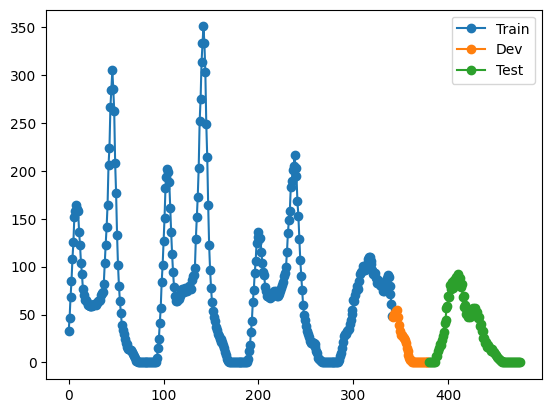

In [20]:
idx = random.randint(0, numbat_train_dataset[0].x.shape[0] -1)

train_val = [snapshot.y[idx] for snapshot in numbat_train_dataset]
dev_val = [snapshot.y[idx] for snapshot in numbat_dev_dataset]
test_val = [snapshot.y[idx] for snapshot in numbat_test_dataset]

num_snap_train = numbat_train_dataset.snapshot_count
num_snap_dev = numbat_dev_dataset.snapshot_count
num_snap_test = numbat_test_dataset.snapshot_count

plt.plot(range(num_snap_train),train_val, label='Train', marker='o')
plt.plot(range(num_snap_train, num_snap_train+ num_snap_dev),dev_val, label='Dev', marker='o')
plt.plot(range(num_snap_train+ num_snap_dev, num_snap_train+ num_snap_dev+num_snap_test),test_val, label='Test', marker='o')
plt.legend()
plt.show()

In [25]:
model = RecurrentGCN(num_lag_features=lag, num_date_features=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion =torch.nn.
criterion =torch.nn.MSELoss()
# criterion =torch.nn.L1Loss()
epochs = 10
epoch_plot = epochs // 10

num_stations = numbat_dev_dataset[0].x.shape[0]
num_links = numbat_dev_dataset[0].edge_index.shape[1]

for epoch in range(epochs):
    ### TRAIN

    model.train()
    print("Epoch", epoch)

    entries_train_loss = 0
    exits_train_loss = 0
    loads_train_loss = 0

    entries_pred_plot = np.empty((num_snap_train, num_stations))
    entries_true_plot = np.empty((num_snap_train, num_stations))

    exits_pred_plot = np.empty((num_snap_train, num_stations))
    exits_true_plot = np.empty((num_snap_train, num_stations))

    loads_pred_plot = np.empty((num_snap_train, num_links))
    loads_true_plot = np.empty((num_snap_train, num_links))

    for time, snapshot in tqdm(enumerate(numbat_train_dataset), total=num_snap_train):
        pred_entries, pred_exits, pred_loads = model(
            snapshot.x, 
            snapshot.features_exits, 
            snapshot.features_loads, 
            snapshot.edge_index, snapshot.edge_attr)
        entries_train_loss = entries_train_loss + criterion(pred_entries, snapshot.y)
        exits_train_loss = exits_train_loss + criterion(pred_exits, snapshot.targets_exits)
        loads_train_loss = loads_train_loss + criterion(pred_loads, snapshot.targets_loads)

        entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
        entries_true_plot[time] = snapshot.y.numpy()

        exits_pred_plot[time] = pred_exits.detach().squeeze().numpy()
        exits_true_plot[time] = snapshot.targets_exits.numpy()

        loads_pred_plot[time] = pred_loads.detach().squeeze().numpy()
        loads_true_plot[time] = snapshot.targets_loads.numpy()
    
    entries_train_loss = entries_train_loss / num_snap_train
    exits_train_loss = exits_train_loss / num_snap_train
    loads_train_loss = loads_train_loss / num_snap_train
    
    train_loss = entries_train_loss + exits_train_loss + loads_train_loss
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch%epoch_plot == 0:
        # print("Train Loss:", train_loss.item())
        print("Train Loss - Entries {}; Exits: {}; Loads {}".format(
            entries_train_loss.item(), exits_train_loss.item(), loads_train_loss.item()
        ))
        
        fig, axs = plt.subplots(2, 3, sharex='row', figsize=(12, 8))

        for ax, col in zip(axs[0], ('St. Entries', 'St. Exits', 'Link Loads')):
            ax.set_title(col)

        for ax, row in zip(axs[:,0], ('Train', 'Dev')):
            ax.set_ylabel(row, size='large')
        axs[0,0].plot(range(num_snap_train),np.mean(entries_true_plot, axis=1), label='Target', marker='o')
        axs[0,0].plot(np.mean(entries_pred_plot, axis=1), label='Predicted', marker='o')

        axs[0,1].plot(np.mean(exits_true_plot, axis=1), label='Target', marker='o')
        axs[0,1].plot(np.mean(exits_pred_plot, axis=1), label='Predicted', marker='o')

        axs[0,2].plot(np.mean(loads_true_plot, axis=1), label='Target', marker='o')
        axs[0,2].plot(np.mean(loads_pred_plot, axis=1), label='Predicted', marker='o')

    ### EVAL
        model.eval()
        entries_dev_loss = 0
        exits_dev_loss = 0
        loads_dev_loss = 0

        entries_pred_plot = np.empty((num_snap_dev, num_stations))
        entries_true_plot = np.empty((num_snap_dev, num_stations))

        exits_pred_plot = np.empty((num_snap_dev, num_stations))
        exits_true_plot = np.empty((num_snap_dev, num_stations))

        loads_pred_plot = np.empty((num_snap_dev, num_links))
        loads_true_plot = np.empty((num_snap_dev, num_links))
        for time, snapshot in tqdm(enumerate(numbat_dev_dataset), total=num_snap_dev):
            pred_entries, pred_exits, pred_loads = model(
                snapshot.x, 
                snapshot.features_exits, 
                snapshot.features_loads, 
                snapshot.edge_index, snapshot.edge_attr)
            
            entries_dev_loss = entries_dev_loss + criterion(pred_entries, snapshot.y)
            exits_dev_loss = exits_dev_loss + criterion(pred_exits, snapshot.targets_exits)
            loads_dev_loss = loads_dev_loss + criterion(pred_loads, snapshot.targets_loads)
        
            entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
            entries_true_plot[time] = snapshot.y.numpy()

            exits_pred_plot[time] = pred_exits.detach().squeeze().numpy()
            exits_true_plot[time] = snapshot.targets_exits.numpy()

            loads_pred_plot[time] = pred_loads.detach().squeeze().numpy()
            loads_true_plot[time] = snapshot.targets_loads.numpy()

        entries_dev_loss = entries_dev_loss / num_snap_dev
        exits_dev_loss = exits_dev_loss / num_snap_dev
        loads_dev_loss = loads_dev_loss / num_snap_dev
        print("Dev Loss - Entries {}; Exits: {}; Loads: {}".format(
            entries_dev_loss.item(), exits_dev_loss.item(), loads_dev_loss.item()
        ))
        axs[1,0].plot(range(num_snap_dev),np.mean(entries_true_plot, axis=1), label='Target', marker='o')
        axs[1,0].plot(np.mean(entries_pred_plot, axis=1), label='Predicted', marker='o')

        axs[1,1].plot(np.mean(exits_true_plot, axis=1), label='Target', marker='o')
        axs[1,1].plot(np.mean(exits_pred_plot, axis=1), label='Predicted', marker='o')

        axs[1,2].plot(np.mean(loads_true_plot, axis=1), label='Target', marker='o')
        axs[1,2].plot(np.mean(loads_pred_plot, axis=1), label='Predicted', marker='o')

        fig.tight_layout()
        plt.legend()
        plt.show()

Epoch 0


 80%|███████▉  | 273/342 [00:06<00:01, 41.57it/s]


KeyboardInterrupt: 

In [23]:
model.eval()
cost = 0
num_snapshot = numbat_test_dataset.snapshot_count
for time, snapshot in tqdm(enumerate(numbat_test_dataset), total=num_snapshot):
    y_hat, _, _ = model(snapshot.x, snapshot.features_exits, snapshot.features_loads, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / num_snapshot
cost = cost.item()
print("MSE Entries: {:.4f}".format(cost))

100%|██████████| 96/96 [00:00<00:00, 107.17it/s]

MSE Entries: 22153.2754


### Sliding Split

In [13]:
numbat_2023_ent_ex_dataset = StaticGraphTemporalSignal(
    edge_index=edge_idx,
    edge_weight=None,
    features=station_entries_features,
    targets=station_entries,
    features_exits=station_exits_features,
    targets_exits=station_exits,
    features_loads=link_loads_features,
    targets_loads=link_loads,
)

n_splits=8
tscv = TimeSeriesSplit(
    n_splits=n_splits,
    max_train_size=192,
    gap=48 #12 hours gap
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

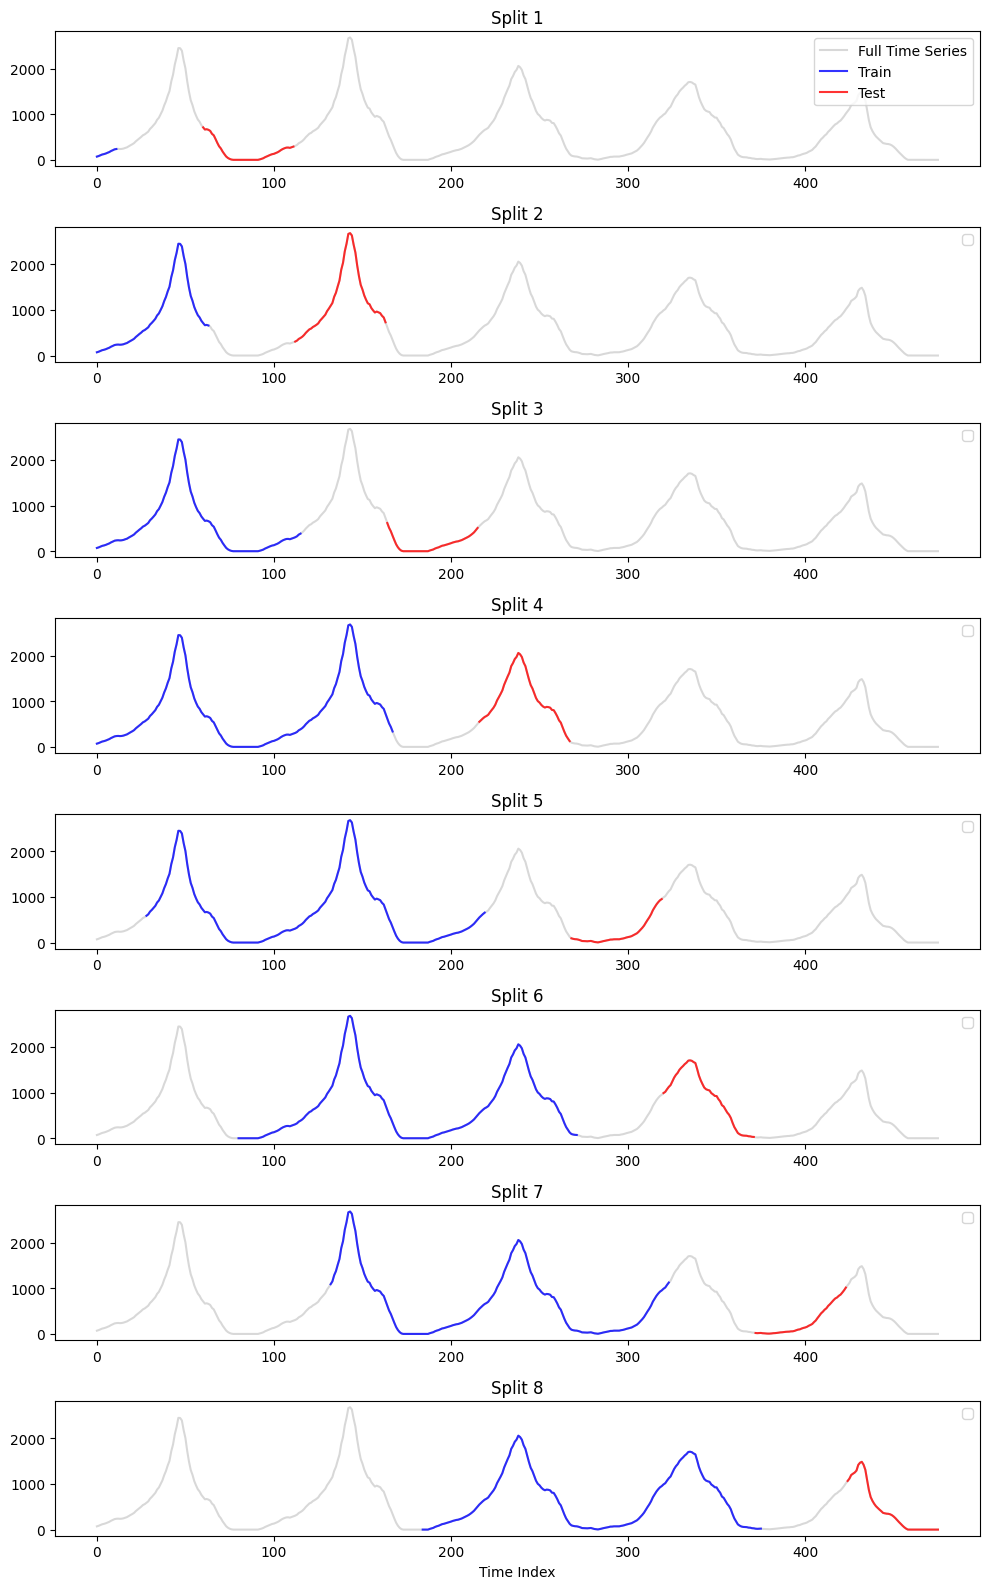

In [15]:
idx = random.randint(0, numbat_2023_ent_ex_dataset[0].x.shape[0] -1)

fig, axes = plt.subplots(n_splits, 1, figsize=(10, 2 * n_splits))
target_val = np.array([snapshot.y[idx] for snapshot in numbat_2023_ent_ex_dataset])

# Loop over the splits and plot train/test sets separately
for i, (train_index, test_index) in enumerate(tscv.split(list(numbat_2023_ent_ex_dataset))):
    ax = axes[i]
    # Plot the full series with low opacity for context
    ax.plot(range(len(target_val)), target_val, color='gray', alpha=0.3, label='Full Time Series' if i == 0 else "")
    
    # Highlight train and test sets
    ax.plot(train_index, target_val[train_index], color='blue', alpha=0.8, label='Train' if i == 0 else "")
    ax.plot(test_index, target_val[test_index], color='red', alpha=0.8, label='Test' if i == 0 else "")
    
    ax.set_title(f"Split {i+1}")
    ax.legend()

# Adjust layout
plt.xlabel("Time Index")
plt.tight_layout()
plt.show()

In [18]:
# criterion =torch.nn.L1Loss()
epochs = 10
epoch_plot = epochs // 10

num_stations = numbat_2023_ent_ex_dataset[0].x.shape[0]
num_links = numbat_2023_ent_ex_dataset[0].edge_index.shape[1]

# all_splits = list(tscv.split(list(numbat_2023_ent_ex_dataset)))
for idx_split, (train_idx, dev_idx) in enumerate(tscv.split(list(numbat_2023_ent_ex_dataset))):
# train_idx, dev_idx = all_splits[idx_split]

    model = RecurrentGCN(num_lag_features=lag, num_date_features=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion =torch.nn.MSELoss()
    
    num_snap_train = len(train_idx)
    num_snap_dev = len(dev_idx)

    for epoch in range(epochs):
        ### TRAIN

        model.train()
        print("Epoch", epoch)

        entries_train_loss = 0
        exits_train_loss = 0
        loads_train_loss = 0

        entries_pred_plot = np.empty((num_snap_train, num_stations))
        entries_true_plot = np.empty((num_snap_train, num_stations))

        exits_pred_plot = np.empty((num_snap_train, num_stations))
        exits_true_plot = np.empty((num_snap_train, num_stations))

        loads_pred_plot = np.empty((num_snap_train, num_links))
        loads_true_plot = np.empty((num_snap_train, num_links))

        for time in tqdm(range(num_snap_train), total=num_snap_train):
            snapshot = numbat_2023_ent_ex_dataset[time]
            pred_entries, pred_exits, pred_loads = model(
                snapshot.x, 
                snapshot.features_exits, 
                snapshot.features_loads, 
                snapshot.edge_index, snapshot.edge_attr)
            entries_train_loss = entries_train_loss + criterion(pred_entries, snapshot.y)
            exits_train_loss = exits_train_loss + criterion(pred_exits, snapshot.targets_exits)
            loads_train_loss = loads_train_loss + criterion(pred_loads, snapshot.targets_loads)

            entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
            entries_true_plot[time] = snapshot.y.numpy()

            exits_pred_plot[time] = pred_exits.detach().squeeze().numpy()
            exits_true_plot[time] = snapshot.targets_exits.numpy()

            loads_pred_plot[time] = pred_loads.detach().squeeze().numpy()
            loads_true_plot[time] = snapshot.targets_loads.numpy()
        
        entries_train_loss = entries_train_loss / num_snap_train
        exits_train_loss = exits_train_loss / num_snap_train
        loads_train_loss = loads_train_loss / num_snap_train
        
        train_loss = entries_train_loss + exits_train_loss + loads_train_loss
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print("Train Loss - Entries {}; Exits: {}; Loads {}".format(
            entries_train_loss.item(), exits_train_loss.item(), loads_train_loss.item()
        ))

        model.eval()
        entries_dev_loss = 0
        exits_dev_loss = 0
        loads_dev_loss = 0

        for time in tqdm(range(num_snap_dev), total=num_snap_dev):
            snapshot = numbat_2023_ent_ex_dataset[time]
            pred_entries, pred_exits, pred_loads = model(
                snapshot.x, 
                snapshot.features_exits, 
                snapshot.features_loads, 
                snapshot.edge_index, snapshot.edge_attr)
            
            entries_dev_loss = entries_dev_loss + criterion(pred_entries, snapshot.y)
            exits_dev_loss = exits_dev_loss + criterion(pred_exits, snapshot.targets_exits)
            loads_dev_loss = loads_dev_loss + criterion(pred_loads, snapshot.targets_loads)

        entries_dev_loss = entries_dev_loss / num_snap_dev
        exits_dev_loss = exits_dev_loss / num_snap_dev
        loads_dev_loss = loads_dev_loss / num_snap_dev

        print("Dev Loss - Entries {}; Exits: {}; Loads: {}".format(
            entries_dev_loss.item(), exits_dev_loss.item(), loads_dev_loss.item()
        ))

Epoch 0


100%|██████████| 12/12 [00:00<00:00, 54.34it/s]


Train Loss - Entries 81711.0; Exits: 107561.9140625; Loads 596978.75


100%|██████████| 52/52 [00:00<00:00, 79.97it/s]


Dev Loss - Entries 82381.8359375; Exits: 83414.84375; Loads: 459426.84375
Epoch 1


100%|██████████| 12/12 [00:00<00:00, 70.02it/s]


Train Loss - Entries 78550.8125; Exits: 104853.4375; Loads 596978.75


100%|██████████| 52/52 [00:00<00:00, 91.47it/s]


Dev Loss - Entries 79827.515625; Exits: 81595.7890625; Loads: 459426.84375
Epoch 2


100%|██████████| 12/12 [00:00<00:00, 85.77it/s]


Train Loss - Entries 75591.8359375; Exits: 103065.2890625; Loads 596978.75


100%|██████████| 52/52 [00:00<00:00, 98.59it/s] 


Dev Loss - Entries 78392.9609375; Exits: 80983.3671875; Loads: 459426.84375
Epoch 3


100%|██████████| 12/12 [00:00<00:00, 76.50it/s]


Train Loss - Entries 73351.2578125; Exits: 102149.9609375; Loads 596978.75


100%|██████████| 52/52 [00:00<00:00, 94.33it/s] 


Dev Loss - Entries 78168.703125; Exits: 81570.9609375; Loads: 459426.84375
Epoch 4


100%|██████████| 12/12 [00:00<00:00, 77.89it/s]


Train Loss - Entries 71905.8828125; Exits: 102108.5234375; Loads 596978.75


100%|██████████| 52/52 [00:00<00:00, 98.55it/s] 


Dev Loss - Entries 79114.046875; Exits: 82723.890625; Loads: 457140.1875
Epoch 5


100%|██████████| 12/12 [00:00<00:00, 77.34it/s]


Train Loss - Entries 71259.59375; Exits: 102594.7890625; Loads 595304.9375


100%|██████████| 52/52 [00:00<00:00, 84.49it/s] 


Dev Loss - Entries 81009.6171875; Exits: 83289.421875; Loads: 444718.0625
Epoch 6


100%|██████████| 12/12 [00:00<00:00, 74.29it/s]


Train Loss - Entries 71338.2421875; Exits: 102853.71875; Loads 581872.875


100%|██████████| 52/52 [00:00<00:00, 83.88it/s]


Dev Loss - Entries 83165.2109375; Exits: 83171.9609375; Loads: 430222.65625
Epoch 7


100%|██████████| 12/12 [00:00<00:00, 79.85it/s]


Train Loss - Entries 71848.265625; Exits: 102739.1953125; Loads 566129.75


100%|██████████| 52/52 [00:00<00:00, 86.31it/s]


Dev Loss - Entries 84680.640625; Exits: 82630.03125; Loads: 408876.78125
Epoch 8


100%|██████████| 12/12 [00:00<00:00, 87.74it/s]


Train Loss - Entries 72315.78125; Exits: 102428.0859375; Loads 542508.1875


100%|██████████| 52/52 [00:00<00:00, 76.96it/s]


Dev Loss - Entries 85122.21875; Exits: 81955.015625; Loads: 382871.96875
Epoch 9


100%|██████████| 12/12 [00:00<00:00, 89.50it/s]


Train Loss - Entries 72449.390625; Exits: 102091.9140625; Loads 511868.625


100%|██████████| 52/52 [00:00<00:00, 100.28it/s]


Dev Loss - Entries 84632.15625; Exits: 81370.5390625; Loads: 365373.28125
Epoch 0


100%|██████████| 64/64 [00:00<00:00, 89.38it/s]


Train Loss - Entries 75967.359375; Exits: 73915.0859375; Loads 408009.78125


100%|██████████| 52/52 [00:00<00:00, 89.07it/s]


Dev Loss - Entries 83447.6796875; Exits: 82766.2421875; Loads: 450739.84375
Epoch 1


100%|██████████| 64/64 [00:00<00:00, 86.58it/s]


Train Loss - Entries 74803.640625; Exits: 71666.390625; Loads 400118.0


100%|██████████| 52/52 [00:00<00:00, 92.00it/s]


Dev Loss - Entries 81459.9609375; Exits: 81323.9140625; Loads: 438459.125
Epoch 2


100%|██████████| 64/64 [00:00<00:00, 96.91it/s] 


Train Loss - Entries 73064.1484375; Exits: 70282.3046875; Loads 388857.65625


100%|██████████| 52/52 [00:00<00:00, 107.94it/s]


Dev Loss - Entries 79769.7421875; Exits: 80922.71875; Loads: 417832.28125
Epoch 3


100%|██████████| 64/64 [00:00<00:00, 97.92it/s] 


Train Loss - Entries 71626.9375; Exits: 69870.8515625; Loads 370179.28125


100%|██████████| 52/52 [00:00<00:00, 82.83it/s]


Dev Loss - Entries 78638.3125; Exits: 81415.328125; Loads: 389343.8125
Epoch 4


100%|██████████| 64/64 [00:00<00:00, 95.90it/s]


Train Loss - Entries 70730.59375; Exits: 70300.09375; Loads 344894.25


100%|██████████| 52/52 [00:00<00:00, 95.87it/s]


Dev Loss - Entries 78046.640625; Exits: 81799.875; Loads: 365871.53125
Epoch 5


100%|██████████| 64/64 [00:00<00:00, 79.75it/s]


Train Loss - Entries 70357.8515625; Exits: 70641.4375; Loads 325866.1875


100%|██████████| 52/52 [00:00<00:00, 80.49it/s]


Dev Loss - Entries 78018.46875; Exits: 81639.421875; Loads: 381520.53125
Epoch 6


100%|██████████| 64/64 [00:00<00:00, 93.97it/s]


Train Loss - Entries 70514.5078125; Exits: 70496.125; Loads 345691.875


100%|██████████| 52/52 [00:00<00:00, 92.74it/s]


Dev Loss - Entries 78274.046875; Exits: 81217.0859375; Loads: 379965.65625
Epoch 7


100%|██████████| 64/64 [00:00<00:00, 102.41it/s]


Train Loss - Entries 70857.3671875; Exits: 70116.4296875; Loads 344019.46875


100%|██████████| 52/52 [00:00<00:00, 103.95it/s]


Dev Loss - Entries 78327.359375; Exits: 80829.515625; Loads: 367043.0
Epoch 8


100%|██████████| 64/64 [00:00<00:00, 96.73it/s]


Train Loss - Entries 70938.5546875; Exits: 69772.9921875; Loads 329653.96875


100%|██████████| 52/52 [00:00<00:00, 87.22it/s]


Dev Loss - Entries 78183.2890625; Exits: 80622.0078125; Loads: 363406.5625
Epoch 9


100%|██████████| 64/64 [00:00<00:00, 97.26it/s] 


Train Loss - Entries 70786.6171875; Exits: 69596.703125; Loads 324082.09375


100%|██████████| 52/52 [00:00<00:00, 100.59it/s]


Dev Loss - Entries 78015.421875; Exits: 80580.6953125; Loads: 367502.8125
Epoch 0


100%|██████████| 116/116 [00:01<00:00, 97.89it/s]


Train Loss - Entries 61302.44140625; Exits: 70683.734375; Loads 362992.5625


100%|██████████| 52/52 [00:00<00:00, 94.54it/s] 


Dev Loss - Entries 82995.3046875; Exits: 81905.546875; Loads: 438662.65625
Epoch 1


100%|██████████| 116/116 [00:01<00:00, 91.47it/s]


Train Loss - Entries 59998.53125; Exits: 69156.703125; Loads 348703.75


100%|██████████| 52/52 [00:00<00:00, 97.41it/s] 


Dev Loss - Entries 81414.1796875; Exits: 80999.6640625; Loads: 415468.53125
Epoch 2


100%|██████████| 116/116 [00:01<00:00, 97.69it/s] 


Train Loss - Entries 58845.12890625; Exits: 68758.2265625; Loads 330991.78125


100%|██████████| 52/52 [00:00<00:00, 94.60it/s]


Dev Loss - Entries 79878.8828125; Exits: 80996.015625; Loads: 386560.15625
Epoch 3


100%|██████████| 116/116 [00:01<00:00, 97.18it/s] 


Train Loss - Entries 57748.91015625; Exits: 69049.1015625; Loads 309763.375


100%|██████████| 52/52 [00:00<00:00, 85.64it/s]


Dev Loss - Entries 78649.609375; Exits: 81037.7109375; Loads: 365126.3125
Epoch 4


100%|██████████| 116/116 [00:01<00:00, 100.31it/s]


Train Loss - Entries 56919.265625; Exits: 69178.0234375; Loads 296796.09375


100%|██████████| 52/52 [00:00<00:00, 90.97it/s]


Dev Loss - Entries 78079.15625; Exits: 80845.0390625; Loads: 378782.84375
Epoch 5


100%|██████████| 116/116 [00:01<00:00, 98.60it/s] 


Train Loss - Entries 56608.3984375; Exits: 68941.2578125; Loads 314787.40625


100%|██████████| 52/52 [00:00<00:00, 91.37it/s]


Dev Loss - Entries 78207.15625; Exits: 80600.640625; Loads: 374353.84375
Epoch 6


100%|██████████| 116/116 [00:01<00:00, 90.17it/s]


Train Loss - Entries 56836.4921875; Exits: 68633.3984375; Loads 310277.4375


100%|██████████| 52/52 [00:00<00:00, 93.10it/s]


Dev Loss - Entries 78522.4296875; Exits: 80441.8203125; Loads: 364668.9375
Epoch 7


100%|██████████| 116/116 [00:01<00:00, 99.18it/s]


Train Loss - Entries 57154.50390625; Exits: 68390.34375; Loads 299219.28125


100%|██████████| 52/52 [00:00<00:00, 98.92it/s] 


Dev Loss - Entries 78505.484375; Exits: 80379.71875; Loads: 363821.84375
Epoch 8


100%|██████████| 116/116 [00:01<00:00, 98.52it/s] 


Train Loss - Entries 57155.640625; Exits: 68252.015625; Loads 295659.65625


100%|██████████| 52/52 [00:00<00:00, 82.27it/s]


Dev Loss - Entries 78237.34375; Exits: 80344.5546875; Loads: 368675.15625
Epoch 9


100%|██████████| 116/116 [00:01<00:00, 96.02it/s]


Train Loss - Entries 56915.59765625; Exits: 68180.3203125; Loads 297739.28125


100%|██████████| 52/52 [00:00<00:00, 94.24it/s]


Dev Loss - Entries 77884.265625; Exits: 80269.984375; Loads: 373000.28125
Epoch 0


100%|██████████| 168/168 [00:02<00:00, 78.89it/s]


Train Loss - Entries 74863.5; Exits: 75171.0625; Loads 392501.34375


100%|██████████| 52/52 [00:00<00:00, 66.65it/s]


Dev Loss - Entries 81507.046875; Exits: 86809.6796875; Loads: 442204.625
Epoch 1


100%|██████████| 168/168 [00:01<00:00, 86.79it/s] 


Train Loss - Entries 72340.921875; Exits: 75171.0625; Loads 378005.1875


100%|██████████| 52/52 [00:00<00:00, 93.55it/s] 


Dev Loss - Entries 79402.3203125; Exits: 86809.6796875; Loads: 419909.53125
Epoch 2


100%|██████████| 168/168 [00:01<00:00, 101.80it/s]


Train Loss - Entries 70781.9140625; Exits: 75171.0625; Loads 359213.40625


100%|██████████| 52/52 [00:00<00:00, 80.86it/s]


Dev Loss - Entries 78205.953125; Exits: 86809.6796875; Loads: 388538.34375
Epoch 3


100%|██████████| 168/168 [00:02<00:00, 70.94it/s]


Train Loss - Entries 70135.5546875; Exits: 75171.0625; Loads 333720.5625


100%|██████████| 52/52 [00:00<00:00, 89.75it/s]


Dev Loss - Entries 78076.21875; Exits: 86809.6796875; Loads: 365222.71875
Epoch 4


100%|██████████| 168/168 [00:01<00:00, 93.50it/s] 


Train Loss - Entries 70460.734375; Exits: 75171.0625; Loads 318409.4375


100%|██████████| 52/52 [00:00<00:00, 96.04it/s]


Dev Loss - Entries 78300.0078125; Exits: 86809.6796875; Loads: 382583.03125
Epoch 5


100%|██████████| 168/168 [00:01<00:00, 97.04it/s] 


Train Loss - Entries 70889.90625; Exits: 75171.0625; Loads 341215.84375


100%|██████████| 52/52 [00:00<00:00, 86.10it/s]


Dev Loss - Entries 78207.703125; Exits: 86809.6796875; Loads: 373480.0625
Epoch 6


100%|██████████| 168/168 [00:01<00:00, 95.36it/s]


Train Loss - Entries 70783.5390625; Exits: 75171.0625; Loads 331023.9375


100%|██████████| 52/52 [00:00<00:00, 96.00it/s] 


Dev Loss - Entries 77945.203125; Exits: 86809.6796875; Loads: 363946.125
Epoch 7


100%|██████████| 168/168 [00:01<00:00, 96.35it/s] 


Train Loss - Entries 70384.0625; Exits: 75171.0625; Loads 318681.5625


100%|██████████| 52/52 [00:00<00:00, 90.94it/s]


Dev Loss - Entries 77779.765625; Exits: 86809.6796875; Loads: 366078.4375
Epoch 8


100%|██████████| 168/168 [00:01<00:00, 98.31it/s] 


Train Loss - Entries 70023.0703125; Exits: 75171.0625; Loads 317591.75


100%|██████████| 52/52 [00:00<00:00, 92.00it/s]


Dev Loss - Entries 77807.5546875; Exits: 86809.6796875; Loads: 370835.96875
Epoch 9


100%|██████████| 168/168 [00:01<00:00, 96.89it/s] 


Train Loss - Entries 69845.0859375; Exits: 75171.0625; Loads 320392.46875


100%|██████████| 52/52 [00:00<00:00, 93.71it/s]


Dev Loss - Entries 77952.4140625; Exits: 86809.6796875; Loads: 371796.1875
Epoch 0


100%|██████████| 192/192 [00:02<00:00, 95.85it/s] 


Train Loss - Entries 65640.2578125; Exits: 65823.5390625; Loads 344199.03125


100%|██████████| 52/52 [00:00<00:00, 95.56it/s] 


Dev Loss - Entries 81708.171875; Exits: 85839.078125; Loads: 442523.5625
Epoch 1


100%|██████████| 192/192 [00:01<00:00, 97.16it/s] 


Train Loss - Entries 63487.703125; Exits: 65055.77734375; Loads 331674.09375


100%|██████████| 52/52 [00:00<00:00, 92.57it/s]


Dev Loss - Entries 79682.90625; Exits: 83790.6640625; Loads: 413954.6875
Epoch 2


100%|██████████| 192/192 [00:02<00:00, 92.67it/s] 


Train Loss - Entries 62198.046875; Exits: 63526.26953125; Loads 310707.53125


100%|██████████| 52/52 [00:00<00:00, 93.17it/s]


Dev Loss - Entries 78385.9296875; Exits: 82153.9609375; Loads: 380980.1875
Epoch 3


100%|██████████| 192/192 [00:02<00:00, 94.23it/s] 


Train Loss - Entries 61585.17578125; Exits: 62363.640625; Loads 287472.71875


100%|██████████| 52/52 [00:00<00:00, 91.30it/s]


Dev Loss - Entries 78129.1796875; Exits: 81222.2421875; Loads: 365329.8125
Epoch 4


100%|██████████| 192/192 [00:02<00:00, 95.87it/s] 


Train Loss - Entries 61795.48046875; Exits: 61804.85546875; Loads 280912.46875


100%|██████████| 52/52 [00:00<00:00, 73.84it/s]


Dev Loss - Entries 78271.453125; Exits: 81097.015625; Loads: 380363.03125
Epoch 5


100%|██████████| 192/192 [00:02<00:00, 70.72it/s]


Train Loss - Entries 62103.0625; Exits: 61891.21484375; Loads 296805.3125


100%|██████████| 52/52 [00:00<00:00, 85.17it/s]


Dev Loss - Entries 78188.3515625; Exits: 81390.0078125; Loads: 368264.78125
Epoch 6


100%|██████████| 192/192 [00:02<00:00, 85.02it/s] 


Train Loss - Entries 62024.84375; Exits: 62256.51953125; Loads 284784.90625


100%|██████████| 52/52 [00:00<00:00, 103.01it/s]


Dev Loss - Entries 77977.15625; Exits: 81544.4609375; Loads: 363344.0625
Epoch 7


100%|██████████| 192/192 [00:01<00:00, 105.72it/s]


Train Loss - Entries 61721.50390625; Exits: 62430.06640625; Loads 277616.21875


100%|██████████| 52/52 [00:00<00:00, 101.86it/s]


Dev Loss - Entries 77823.15625; Exits: 81418.59375; Loads: 368555.125
Epoch 8


100%|██████████| 192/192 [00:01<00:00, 106.18it/s]


Train Loss - Entries 61427.42578125; Exits: 62317.44140625; Loads 279545.28125


100%|██████████| 52/52 [00:00<00:00, 94.97it/s]


Dev Loss - Entries 77830.2890625; Exits: 81138.6640625; Loads: 374230.3125
Epoch 9


100%|██████████| 192/192 [00:01<00:00, 102.51it/s]


Train Loss - Entries 61265.046875; Exits: 62045.41796875; Loads 282954.03125


100%|██████████| 52/52 [00:00<00:00, 89.53it/s] 


Dev Loss - Entries 77932.84375; Exits: 80865.0546875; Loads: 375911.625
Epoch 0


100%|██████████| 192/192 [00:01<00:00, 100.67it/s]


Train Loss - Entries 63839.04296875; Exits: 65821.7734375; Loads 344203.59375


100%|██████████| 52/52 [00:00<00:00, 103.95it/s]


Dev Loss - Entries 80335.046875; Exits: 86254.1171875; Loads: 450236.875
Epoch 1


100%|██████████| 192/192 [00:01<00:00, 103.55it/s]


Train Loss - Entries 62596.359375; Exits: 65456.3125; Loads 337187.78125


100%|██████████| 52/52 [00:00<00:00, 110.17it/s]


Dev Loss - Entries 79034.765625; Exits: 83967.3671875; Loads: 439049.96875
Epoch 2


100%|██████████| 192/192 [00:01<00:00, 107.18it/s]


Train Loss - Entries 61834.6875; Exits: 63797.38671875; Loads 328833.90625


100%|██████████| 52/52 [00:00<00:00, 101.17it/s]


Dev Loss - Entries 78295.0546875; Exits: 81976.9609375; Loads: 420901.875
Epoch 3


100%|██████████| 192/192 [00:01<00:00, 104.18it/s]


Train Loss - Entries 61566.80859375; Exits: 62322.0625; Loads 315456.28125


100%|██████████| 52/52 [00:00<00:00, 101.36it/s]


Dev Loss - Entries 78149.890625; Exits: 80896.9609375; Loads: 395565.375
Epoch 4


100%|██████████| 192/192 [00:01<00:00, 106.77it/s]


Train Loss - Entries 61747.69140625; Exits: 61593.00390625; Loads 297301.96875


100%|██████████| 52/52 [00:00<00:00, 103.09it/s]


Dev Loss - Entries 78171.1328125; Exits: 80838.9609375; Loads: 370477.65625
Epoch 5


100%|██████████| 192/192 [00:01<00:00, 105.71it/s]


Train Loss - Entries 61873.296875; Exits: 61692.69921875; Loads 281244.1875


100%|██████████| 52/52 [00:00<00:00, 108.25it/s]


Dev Loss - Entries 78140.078125; Exits: 81295.265625; Loads: 373461.71875
Epoch 6


100%|██████████| 192/192 [00:01<00:00, 102.66it/s]


Train Loss - Entries 61831.828125; Exits: 62166.875; Loads 290684.53125


100%|██████████| 52/52 [00:00<00:00, 104.62it/s]


Dev Loss - Entries 78065.8828125; Exits: 81493.9609375; Loads: 376439.78125
Epoch 7


100%|██████████| 192/192 [00:01<00:00, 102.34it/s]


Train Loss - Entries 61704.53125; Exits: 62364.359375; Loads 293815.53125


100%|██████████| 52/52 [00:00<00:00, 106.55it/s]


Dev Loss - Entries 78004.84375; Exits: 81303.1796875; Loads: 367520.46875
Epoch 8


100%|██████████| 192/192 [00:01<00:00, 105.45it/s]


Train Loss - Entries 61555.0; Exits: 62195.94921875; Loads 284077.3125


100%|██████████| 52/52 [00:00<00:00, 91.40it/s]


Dev Loss - Entries 77984.734375; Exits: 80958.5390625; Loads: 364639.4375
Epoch 9


100%|██████████| 192/192 [00:01<00:00, 109.47it/s]


Train Loss - Entries 61436.91015625; Exits: 61875.28515625; Loads 278947.0625


100%|██████████| 52/52 [00:00<00:00, 109.34it/s]


Dev Loss - Entries 77981.25; Exits: 80658.6171875; Loads: 367750.6875
Epoch 0


100%|██████████| 192/192 [00:01<00:00, 100.52it/s]


Train Loss - Entries 65635.3046875; Exits: 65823.6484375; Loads 344203.59375


100%|██████████| 52/52 [00:00<00:00, 67.42it/s]


Dev Loss - Entries 84750.7890625; Exits: 86809.6796875; Loads: 454665.375
Epoch 1


100%|██████████| 192/192 [00:02<00:00, 81.80it/s]


Train Loss - Entries 65622.2734375; Exits: 65823.6484375; Loads 340669.5625


100%|██████████| 52/52 [00:00<00:00, 86.03it/s]


Dev Loss - Entries 82668.796875; Exits: 86809.6796875; Loads: 447873.1875
Epoch 2


100%|██████████| 192/192 [00:02<00:00, 89.48it/s]


Train Loss - Entries 64146.9375; Exits: 65823.6484375; Loads 335555.28125


100%|██████████| 52/52 [00:00<00:00, 80.31it/s]


Dev Loss - Entries 80689.3359375; Exits: 86809.6796875; Loads: 436015.3125
Epoch 3


100%|██████████| 192/192 [00:02<00:00, 90.67it/s]


Train Loss - Entries 62802.89453125; Exits: 65823.6484375; Loads 326728.40625


100%|██████████| 52/52 [00:00<00:00, 88.77it/s]


Dev Loss - Entries 78962.53125; Exits: 86809.6796875; Loads: 417227.15625
Epoch 4


100%|██████████| 192/192 [00:02<00:00, 80.62it/s]


Train Loss - Entries 61751.578125; Exits: 65823.6484375; Loads 312931.0


100%|██████████| 52/52 [00:00<00:00, 90.79it/s]


Dev Loss - Entries 77993.59375; Exits: 86809.6796875; Loads: 391280.4375
Epoch 5


100%|██████████| 192/192 [00:02<00:00, 83.70it/s]


Train Loss - Entries 61397.203125; Exits: 65823.6484375; Loads 294435.34375


100%|██████████| 52/52 [00:00<00:00, 104.71it/s]


Dev Loss - Entries 77887.140625; Exits: 86809.6796875; Loads: 366953.28125
Epoch 6


100%|██████████| 192/192 [00:01<00:00, 103.38it/s]


Train Loss - Entries 61693.48046875; Exits: 65823.6484375; Loads 279084.21875


100%|██████████| 52/52 [00:00<00:00, 101.17it/s]


Dev Loss - Entries 78034.640625; Exits: 86809.6796875; Loads: 376229.4375
Epoch 7


100%|██████████| 192/192 [00:01<00:00, 100.74it/s]


Train Loss - Entries 61993.33203125; Exits: 65823.6484375; Loads 292974.84375


100%|██████████| 52/52 [00:00<00:00, 99.19it/s] 


Dev Loss - Entries 78007.328125; Exits: 86809.6796875; Loads: 377015.0
Epoch 8


100%|██████████| 192/192 [00:01<00:00, 102.18it/s]


Train Loss - Entries 61967.70703125; Exits: 65823.6484375; Loads 293818.09375


100%|██████████| 52/52 [00:00<00:00, 102.05it/s]


Dev Loss - Entries 77792.71875; Exits: 86809.6796875; Loads: 366124.46875
Epoch 9


100%|██████████| 192/192 [00:01<00:00, 98.06it/s] 


Train Loss - Entries 61675.53125; Exits: 65823.6484375; Loads 282556.96875


100%|██████████| 52/52 [00:00<00:00, 102.29it/s]


Dev Loss - Entries 77571.8125; Exits: 86809.6796875; Loads: 363255.5625
Epoch 0


100%|██████████| 192/192 [00:01<00:00, 105.29it/s]


Train Loss - Entries 65640.484375; Exits: 65823.6484375; Loads 344203.59375


100%|██████████| 52/52 [00:00<00:00, 95.18it/s] 


Dev Loss - Entries 83718.1953125; Exits: 86809.6796875; Loads: 451598.03125
Epoch 1


100%|██████████| 192/192 [00:01<00:00, 99.91it/s] 


Train Loss - Entries 64873.03515625; Exits: 65823.6484375; Loads 338328.46875


100%|██████████| 52/52 [00:00<00:00, 98.28it/s]


Dev Loss - Entries 81286.40625; Exits: 86809.6796875; Loads: 437711.0625
Epoch 2


100%|██████████| 192/192 [00:01<00:00, 106.60it/s]


Train Loss - Entries 63199.3125; Exits: 65823.6484375; Loads 327945.03125


100%|██████████| 52/52 [00:00<00:00, 103.22it/s]


Dev Loss - Entries 79266.8828125; Exits: 86809.6796875; Loads: 415873.125
Epoch 3


100%|██████████| 192/192 [00:01<00:00, 104.31it/s]


Train Loss - Entries 61950.05078125; Exits: 65823.6484375; Loads 311874.21875


100%|██████████| 52/52 [00:00<00:00, 96.15it/s]


Dev Loss - Entries 78193.078125; Exits: 86809.6796875; Loads: 386925.53125
Epoch 4


100%|██████████| 192/192 [00:01<00:00, 100.50it/s]


Train Loss - Entries 61519.46484375; Exits: 65823.6484375; Loads 291393.34375


100%|██████████| 52/52 [00:00<00:00, 102.61it/s]


Dev Loss - Entries 78098.3828125; Exits: 86809.6796875; Loads: 365259.0
Epoch 5


100%|██████████| 192/192 [00:02<00:00, 95.56it/s] 


Train Loss - Entries 61848.17578125; Exits: 65823.6484375; Loads 279298.71875


100%|██████████| 52/52 [00:00<00:00, 100.69it/s]


Dev Loss - Entries 78261.828125; Exits: 86809.6796875; Loads: 382762.15625
Epoch 6


100%|██████████| 192/192 [00:01<00:00, 103.24it/s]


Train Loss - Entries 62172.87890625; Exits: 65823.6484375; Loads 299899.09375


100%|██████████| 52/52 [00:00<00:00, 98.73it/s] 


Dev Loss - Entries 78169.8671875; Exits: 86809.6796875; Loads: 373760.78125
Epoch 7


100%|██████████| 192/192 [00:01<00:00, 104.20it/s]


Train Loss - Entries 62098.11328125; Exits: 65823.6484375; Loads 290992.875


100%|██████████| 52/52 [00:00<00:00, 104.93it/s]


Dev Loss - Entries 77912.015625; Exits: 86809.6796875; Loads: 364153.21875
Epoch 8


100%|██████████| 192/192 [00:01<00:00, 103.28it/s]


Train Loss - Entries 61771.73046875; Exits: 65823.6484375; Loads 280040.40625


100%|██████████| 52/52 [00:00<00:00, 90.81it/s]


Dev Loss - Entries 77703.609375; Exits: 86809.6796875; Loads: 365028.15625
Epoch 9


100%|██████████| 192/192 [00:01<00:00, 103.38it/s]


Train Loss - Entries 61443.70703125; Exits: 65823.6484375; Loads 277999.4375


100%|██████████| 52/52 [00:00<00:00, 105.56it/s]

Dev Loss - Entries 77618.703125; Exits: 86809.6796875; Loads: 370065.15625


In [ ]:
model.eval()
cost = 0
num_snapshot = numbat_test_dataset.snapshot_count
for time, snapshot in tqdm(enumerate(numbat_test_dataset), total=num_snapshot):
    y_hat, _, _ = model(snapshot.x, snapshot.features_exits, snapshot.features_loads, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / num_snapshot
cost = cost.item()
print("MSE Entries: {:.4f}".format(cost))

100%|██████████| 96/96 [00:00<00:00, 107.17it/s]

MSE Entries: 22153.2754
